两种常见的迁移学习方案：
- 微调：替换随机初始化，使用预训练的网络取初始化参数
- 卷积网络做为特征提取器：冻结全连接层之前的所有参数，使用新的全连接层替换现有的

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

## 加载数据

使用`torchvision`和`torch.utils.data`包加载数据。

本示例解决一个蚂蚁和蜜蜂分类的问题，每个类别各使用120张训练数据，75张验证数据。如果从头训练，这将是一个非常小的数据集，我们可以使用迁移学习。

In [3]:
# 数据变换方式
data_transforms = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    "val":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = r"E:\DataSet\pytorch\hymenoptera_data"

In [5]:
# 分别创建了train, val 两个dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ["train", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ["train", "val"]}

data_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 一些数据的可视化

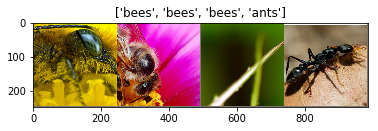

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### 训练模型

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 每轮都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == "train":
                model.train() # 设置模型为训练模式
            else:
                model.eval() # 设置模型为评估模式
                
            running_loss = 0.0
            running_corrects = 0
            
            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                # 前向传播，仅有训练时跟踪数据
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # 统计数据
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # 深拷贝模型
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 加载最好的模型
    model.load_state_dict(best_model_wts)
    return model

### 可视化模型预测

In [42]:
def visualize_model(model, num_image=6):
    was_training = model.training
    model.eval()
    image_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                image_so_far += 1
                ax = plt.subplot(num_image // 2, 2, image_so_far)
                ax.axis("off")
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if image_so_far == num_image:
                    model.train(mode = was_training)
                    return
                
        model.train(mode=was_training)

### 微调卷积

In [19]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\SongZQ/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [01:20<00:00, 584kB/s]


In [26]:
# 修改预训练模型的全连接层，得到新模型
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()

# 更新所有参数
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

# 没7个周期将学习率衰减0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [38]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6363 Acc: 0.7336
val Loss: 0.6216 Acc: 0.7908

Epoch 1/24
----------
train Loss: 0.6715 Acc: 0.7828
val Loss: 0.7998 Acc: 0.7647

Epoch 2/24
----------
train Loss: 0.7514 Acc: 0.7459
val Loss: 0.7014 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.7171 Acc: 0.7459
val Loss: 0.3845 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5767 Acc: 0.7418
val Loss: 0.4438 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4644 Acc: 0.8320
val Loss: 0.7051 Acc: 0.7778

Epoch 6/24
----------
train Loss: 0.4882 Acc: 0.7951
val Loss: 0.4443 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3712 Acc: 0.8811
val Loss: 0.3752 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3297 Acc: 0.8689
val Loss: 0.3186 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2338 Acc: 0.9057
val Loss: 0.3398 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3201 Acc: 0.8443
val Loss: 0.3060 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.1987 Acc: 0.9344
val Loss: 0.2967 Acc: 0.9216

Ep

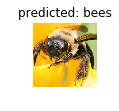

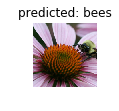

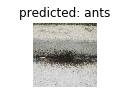

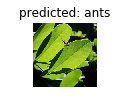

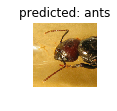

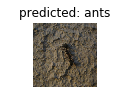

In [43]:
visualize_model(model_ft)

## 使用卷积网络提取图像特征
冻结网络最后一层之外的参数，我们需要设置`requires_grad == False`,这样在反向传播时它们不会参与计算

In [45]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [46]:
# 冻结所有参数
for param in model_conv.parameters():
    param.requires_grad = False

In [47]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

In [50]:
criterion = nn.CrossEntropyLoss()

# 只有最有一层的参数被优化
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [51]:
# 速度较前种方法快了近一倍
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6401 Acc: 0.6270
val Loss: 0.1947 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5093 Acc: 0.7459
val Loss: 0.1781 Acc: 0.9673

Epoch 2/24
----------
train Loss: 0.5205 Acc: 0.7541
val Loss: 0.1644 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5573 Acc: 0.7664
val Loss: 0.1856 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4919 Acc: 0.7869
val Loss: 0.1705 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.5545 Acc: 0.7664
val Loss: 0.3315 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.6201 Acc: 0.7336
val Loss: 0.3304 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3353 Acc: 0.8402
val Loss: 0.2004 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3188 Acc: 0.8484
val Loss: 0.2206 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4035 Acc: 0.8074
val Loss: 0.2243 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3758 Acc: 0.8361
val Loss: 0.2226 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3587 Acc: 0.8566
val Loss: 0.2015 Acc: 0.9346

Ep

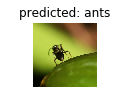

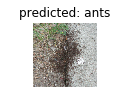

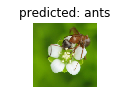

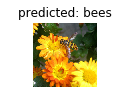

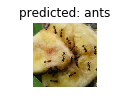

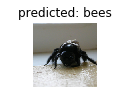

In [52]:
visualize_model(model_conv)

plt.ioff()
plt.show()